# Segunda parte: Aspectos prácticos de las redes neuronales

En esta segunda parte, vamos a continuar desarrollando el problema de Fashion MNIST, con el objetivo de entender los aspectos prácticos del entrenamiento de redes neuronales que hemos visto en el Tema 4.

El código utilizado para contestar tiene que quedar claramente reflejado en el Notebook. Puedes crear nuevas cells si así lo deseas para estructurar tu código y sus salidas. A la hora de entregar el notebook, **asegúrate de que los resultados de ejecutar tu código han quedado guardados**. 

In [1]:
import keras
from keras.datasets import fashion_mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from keras.callbacks import EarlyStopping
import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers
from sklearn.metrics import classification_report, confusion_matrix


import matplotlib
import matplotlib.pyplot as plt


import time
import numpy as np
import pandas as pd

np.random.seed(0)

import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
#import tensorflow as tf
#from keras.backend import tensorflow_backend
#config = tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth=True))
#session = tf.Session(config=config)
#tensorflow_backend.set_session(session)
## required for efficient GPU use

#### Obtención de los datos y pre-processing

In [3]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train = x_train / 255.0
x_test = x_test / 255.0

## Consideraciones iniciales

### Train-validation-test split

En todos los modelos que entrenemos, vamos a partir los datos de training (x_train) en dos sets: training y validación. De este modo, al final tendremos tres datasets distintos: training, validation, y test. Esta es una estrategia común en el aprendizaje automático, en la que los datos de test (o held-out data) se 
"esconden" hasta el final. Los datos de validación se utilizan para estimar cómo de bien están funcionando nuestros modelos y para observar si estamos cayendo en overfitting. Esto nos permite cambiar hiperparámetros y probar distintas arquitecturas **sabiendo que no estamos utilizando información del test set para "optimizar" los resultados en éste** (si eligiéramos nuestro mejor modelo en base a los resultados de test, estaríamos "haciendo trampas", ya que se ha utilizado la información contenida en éste para elegir el modelo y las métricas reportadas serían optimistas).

Para utilizar un split training-validation data durante el entrenamiento, podemos partir nosotros mismos los datos o dejar que Keras lo haga. Podéis ver cómo hacer estas particiones en la documentación de *fit*.

**Requisito: En todos los entrenamientos de esta práctica, se requiere utilizar el 20% de los datos en x_train como  conjunto de datos de validación**

### Un error común con modelos de Keras

En esta práctica entrenaremos varios modelos para comparar resultados. Un error común en Keras es no instanciar un nuevo modelo cada vez que hacemos un nuevo entrenamiento. Al hacer

*model = Sequential()*

*model.add(lo que sea)  # Definición del modelo*

*model.fit()*

si queremos entrenar un nuevo modelo o el mismo modelo otra vez, es necesario volver a inicializar el modelo con model = Sequential(). Si olvidamos este paso y volvemos a hacer fit(), el modelo seguirá entrenando por donde se quedó en el último fit().

### Análisis de resultados 

A la hora de escribir las respuestas y los análisis pedidos, es importante presentar las conclusiones de manera adecuada a partir de lo visto en nuestros experimentos. Los Jupyter Notebook son una herramienta imprescindible para *data scientists* e ingenieros de Machine Learning para presentar los resultados, incluyendo soporte para incluir gráficas y elementos visuales. Podéis explicar vuestras observaciones del modo que consideréis adecuado, si bien recomendamos la utilización de gráficas para evaluar los entrenamientos y comparar resultados.

Como ayuda, las siguientes funciones pueden resultar interesantes a la hora de evaluar resultados. Todas ellas utilizan el objeto *history* que podéis obtener como salida del método *fit()* de Keras:

history = model.fit(x_train, y_train, ...)

Por supuesto, podéis modificarlas y utilizarlas como prefiráis para crear vuestros propios informes.

## 1. Unidades de activación

En este ejercicio, vamos a evaluar la importancia de utilizar las unidades de activación adecuadas. Como hemos visto en clase, funciones de activación como sigmoid han dejado de utilizarse en favor de otras unidades como ReLU.

**Ejercicio 1 *(1.25 puntos)***: Partiendo de una red sencilla como la desarrollada en el Trabajo 1, escribir un breve análisis comparando la utilización de unidades sigmoid y ReLU (por ejemplo, se pueden comentar aspectos como velocidad de convergencia, métricas obtenidas...). Explicar por qué pueden darse estas diferencias. Opcionalmente, comparar con otras activaciones disponibles en Keras.

*Pista: Usando redes más grandes se hace más sencillo apreciar las diferencias. Es mejor utilizar al menos 3 o 4 capas densas.*

Incluyo aqui las funciones para graficar que son usadas después, pero con algunos cambios a las originales.

In [4]:
def plot_acc(history, title="Model Accuracy"):
    """Imprime una gráfica mostrando la accuracy por epoch obtenida en un entrenamiento"""
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.grid(True)
    plt.show()
    
def plot_loss(history, title="Model Loss"):
    """Imprime una gráfica mostrando la pérdida por epoch obtenida en un entrenamiento"""
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper right')
    plt.show()
    
def plot_compare_losses(history1, history2, name1="Red 1",
                        name2="Red 2", title="Graph title"):
    """Compara losses de dos entrenamientos con nombres name1 y name2"""
    plt.plot(history1.history['loss'], color="green")
    plt.plot(history1.history['val_loss'], 'r--', color="green")
    plt.plot(history2.history['loss'], color="blue")
    plt.plot(history2.history['val_loss'], 'r--', color="blue")
    plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train ' + name1, 'Val ' + name1, 
                'Train ' + name2, 'Val ' + name2],
               loc='upper right')
    plt.show()
    
def plot_compare_accs(history1, history2, name1="Red 1",
                      name2="Red 2", title="Graph title"):
    """Compara accuracies de dos entrenamientos con nombres name1 y name2"""
    plt.plot(history1.history['accuracy'], color="green")
    plt.plot(history1.history['val_accuracy'], 'r--', color="green")
    plt.plot(history2.history['accuracy'], color="blue")
    plt.plot(history2.history['val_accuracy'], 'r--', color="blue")
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train ' + name1, 'Val ' + name1, 
                'Train ' + name2, 'Val ' + name2], 
               loc='lower right')
    plt.show()

* Información básica de los conjuntos de datos

In [5]:
print('Número de imagenes en dataset de entrenamiento: ', x_train.shape[0])
print('Número de pixeles de cada imagen: ', x_train.shape[1], ' x ', x_train.shape[2])
print('Número de imagenes en dataset de test: ', x_test.shape[0])
print("Clases a predecir: ", np.unique(y_train))

Número de imagenes en dataset de entrenamiento:  60000
Número de pixeles de cada imagen:  28  x  28
Número de imagenes en dataset de test:  10000
Clases a predecir:  [0 1 2 3 4 5 6 7 8 9]


### Para la resolución de este apartado, hemos decidido usar siete funciones de activación que ofrece keras y vamos a realizar una comparación teniendo en cuenta el tiempo de ejecución y los valores de accuracy en el dataset de test y validación. Hay que remarcar que cada vez que se ejecuta los resultados pueden ser distintos. Vamos a comentar el ejercicion con la última ejecución realizada.

### Para todos los modelos de esta sección vamos a partir del modelo realizado en la primera parte de esta actividad, cambiamos en cada modelo la función de activación, desactivamos la monitorización de los mismos por petición de la propia actividad, e introducimos el cálculo del tiempo en ejcucción. Pedimos un resumen despues de la realización de éstos.

# Modelo 1: Usando tres funciones de activación intermedias del tipo Sigmoid, creando un conjunto de validación con el 20% de las imagenes del dataset test.

In [6]:
start1 = time.time()
model_1 = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(128, activation='sigmoid'),
    keras.layers.Dense(64, activation='sigmoid'),
    keras.layers.Dense(64, activation='sigmoid'),
    keras.layers.Dense(10, activation='softmax')
])


model_1.compile(optimizer='sgd',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history_1 = model_1.fit(x_train, y_train, epochs=20, batch_size= 64,  validation_split = 0.2, shuffle=True, verbose= 0)

end1 = time.time()

end1_1 = end1 - start1

print("Tiempo de ejecución del modelo 1 en segundos:", end1 - start1)
print("La accuracy en entrenamiento del modelo_1 es: ", np.max(history_1.history['accuracy']))
print("La accuracy en validación del modelo_1 es: ", np.max(history_1.history['val_accuracy']))


Tiempo de ejecución del modelo 1 en segundos: 44.25123953819275
La accuracy en entrenamiento del modelo_1 es:  0.6657708
La accuracy en validación del modelo_1 es:  0.6712499856948853


* Para todos los modelos vamos a pedir un resumen que nos indique el tipo de modelo, el tipo de capa, neuronas por capas y parametros tanto por capas como el total.

In [7]:
model_1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_4 (Dense)              (None, 10)                650       
Total params: 113,546
Trainable params: 113,546
Non-trainable params: 0
_________________________________________________________________


## Modelo 2: Usando tres funciones de activación intermedias del tipo Relu, creando un conjunto de validación con el 20% de las imagenes del dataset test.

In [8]:
start2 = time.time()
model_2 = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])


model_2.compile(optimizer='sgd',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history_2 = model_2.fit(x_train, y_train, epochs=20, batch_size= 64,validation_split=0.2, verbose=0, shuffle=True)

end2 = time.time()

end2_1 = end2 - start2

print("Tiempo de ejecución del modelo 2 en segundos:", end2 - start2)
print("La accuracy en entrenamiento del modelo_2 es: ", np.max(history_2.history['accuracy']))
print("La accuracy en validación del modelo_2 es: ", np.max(history_2.history['val_accuracy']))


Tiempo de ejecución del modelo 2 en segundos: 43.33907508850098
La accuracy en entrenamiento del modelo_2 es:  0.8855
La accuracy en validación del modelo_2 es:  0.8743333220481873


In [9]:
model_2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_6 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_7 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_8 (Dense)              (None, 10)                650       
Total params: 113,546
Trainable params: 113,546
Non-trainable params: 0
_________________________________________________________________


# Modelo 3: Usando tres funciones de activación intermedias del tipo Tangente hipebólica, creando un conjunto de validación con el 20% de las imagenes del dataset test.

In [10]:
start3 = time.time()
model_3 = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(128, activation='tanh'),
    keras.layers.Dense(64, activation='tanh'),
    keras.layers.Dense(64, activation='tanh'),
    keras.layers.Dense(10, activation='softmax')
])


model_3.compile(optimizer='sgd',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history_3 = model_3.fit(x_train, y_train, epochs=20, batch_size= 64,  validation_split = 0.2, shuffle=True, verbose= 0)

end3 = time.time()

end3_1 = end3 - start3

print("Tiempo de ejecución del modelo 3 en segundos:", end3 - start3)


print("La accuracy en entrenamiento del modelo_3 es: ", np.max(history_3.history['accuracy']))
print("La accuracy en validación del modelo_3 es: ", np.max(history_3.history['val_accuracy']))


Tiempo de ejecución del modelo 3 en segundos: 44.75730800628662
La accuracy en entrenamiento del modelo_3 es:  0.8830208
La accuracy en validación del modelo_3 es:  0.871666669845581


In [11]:
model_3.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_10 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_11 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_12 (Dense)             (None, 10)                650       
Total params: 113,546
Trainable params: 113,546
Non-trainable params: 0
_________________________________________________________________


# Modelo 4: Usando tres funciones de activación intermedias del tipo Hard_Sigmoid, creando un conjunto de validación con el 20% de las imagenes del dataset test.

In [12]:
start4 = time.time()
model_4 = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(128, activation='hard_sigmoid'),
    keras.layers.Dense(64, activation='hard_sigmoid'),
    keras.layers.Dense(64, activation='hard_sigmoid'),
    keras.layers.Dense(10, activation='softmax')
])


model_4.compile(optimizer='sgd',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history_4 = model_4.fit(x_train, y_train, epochs=20, batch_size= 64,  validation_split = 0.2, shuffle=True, verbose= 0)

end4 = time.time()

end4_1 = end4 - start4

print("Tiempo de ejecución del modelo 4 en segundos:", end4 - start4)


print("La accuracy en entrenamiento del modelo_4 es: ", np.max(history_4.history['accuracy']))
print("La accuracy en validación del modelo_4 es: ", np.max(history_4.history['val_accuracy']))


Tiempo de ejecución del modelo 4 en segundos: 46.581517696380615
La accuracy en entrenamiento del modelo_4 es:  0.6169375
La accuracy en validación del modelo_4 es:  0.6333333253860474


In [13]:
model_4.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 128)               100480    
_________________________________________________________________
dense_14 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_15 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_16 (Dense)             (None, 10)                650       
Total params: 113,546
Trainable params: 113,546
Non-trainable params: 0
_________________________________________________________________


# Modelo 5: Usando tres funciones de activación intermedias del tipo Softplus, creando un conjunto de validación con el 20% de las imagenes del dataset test.

In [14]:
start5 = time.time()
model_5 = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(128, activation='softplus'),
    keras.layers.Dense(64, activation='softplus'),
    keras.layers.Dense(64, activation='softplus'),
    keras.layers.Dense(10, activation='softmax')
])


model_5.compile(optimizer='sgd',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history_5 = model_5.fit(x_train, y_train, epochs=20, batch_size= 64,  validation_split = 0.2, shuffle=True, verbose= 0)

end5 = time.time()

end5_1 = end5 - start5


print("Tiempo de ejecución del modelo 5 en segundos:", end5 - start5)


print("La accuracy en entrenamiento del modelo_5 es: ", np.max(history_5.history['accuracy']))
print("La accuracy en validación del modelo_5 es: ", np.max(history_5.history['val_accuracy']))


Tiempo de ejecución del modelo 5 en segundos: 45.13154911994934
La accuracy en entrenamiento del modelo_5 es:  0.861
La accuracy en validación del modelo_5 es:  0.8566666841506958


In [15]:
model_5.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_5 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 128)               100480    
_________________________________________________________________
dense_18 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_19 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_20 (Dense)             (None, 10)                650       
Total params: 113,546
Trainable params: 113,546
Non-trainable params: 0
_________________________________________________________________


# Modelo 6: Usando tres funciones de activación intermedias del tipo Selu, creando un conjunto de validación con el 20% de las imagenes del dataset test.

In [16]:
start6 = time.time()
model_6 = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(128, activation='selu'),
    keras.layers.Dense(64, activation='selu'),
    keras.layers.Dense(64, activation='selu'),
    keras.layers.Dense(10, activation='softmax')
])


model_6.compile(optimizer='sgd',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history_6 = model_6.fit(x_train, y_train, epochs=20, batch_size= 64,  validation_split = 0.2, shuffle=True, verbose= 0)

end6 = time.time()

end6_1 = end6 - start6

print("Tiempo de ejecución del modelo 6 en segundos:", end6 - start6)


print("La accuracy en entrenamiento del modelo_6 es: ", np.max(history_6.history['accuracy']))
print("La accuracy en validación del modelo_6 es: ", np.max(history_6.history['val_accuracy']))


Tiempo de ejecución del modelo 6 en segundos: 46.92238736152649
La accuracy en entrenamiento del modelo_6 es:  0.88935417
La accuracy en validación del modelo_6 es:  0.8735833168029785


In [17]:
model_6.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_6 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 128)               100480    
_________________________________________________________________
dense_22 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_23 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_24 (Dense)             (None, 10)                650       
Total params: 113,546
Trainable params: 113,546
Non-trainable params: 0
_________________________________________________________________


# Modelo 7: Usando tres funciones de activación intermedias del tipo Elu, creando un conjunto de validación con el 20% de las imagenes del dataset test.

In [18]:
start7 = time.time()
model_7 = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(128, activation='elu'),
    keras.layers.Dense(64, activation='elu'),
    keras.layers.Dense(64, activation='elu'),
    keras.layers.Dense(10, activation='softmax')
])


model_7.compile(optimizer='sgd',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history_7 = model_7.fit(x_train, y_train, epochs=20, batch_size= 64,  validation_split = 0.2, shuffle=True, verbose= 0)

end7 = time.time()



end7_1 = end7 - start7

print("Tiempo de ejecución del modelo 7 en segundos:", end7 - start7)


print("La accuracy en entrenamiento del modelo_7 es: ", np.max(history_7.history['accuracy']))
print("La accuracy en validación del modelo_7 es: ", np.max(history_7.history['val_accuracy']))


Tiempo de ejecución del modelo 7 en segundos: 41.13523817062378
La accuracy en entrenamiento del modelo_7 es:  0.8798125
La accuracy en validación del modelo_7 es:  0.8723333477973938


In [19]:
model_7.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_7 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 128)               100480    
_________________________________________________________________
dense_26 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_27 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_28 (Dense)             (None, 10)                650       
Total params: 113,546
Trainable params: 113,546
Non-trainable params: 0
_________________________________________________________________


* Vamos a crear un dataframe con los valores devueltos por los modelos para facilitar su comprensión.

In [20]:
acc_1 = round(np.max(history_1.history['accuracy']),4)
acc_2 = round(np.max(history_2.history['accuracy']),4)
acc_3 = round(np.max(history_3.history['accuracy']),4)
acc_4 = round(np.max(history_4.history['accuracy']),4)
acc_5 = round(np.max(history_5.history['accuracy']),4)
acc_6 = round(np.max(history_6.history['accuracy']),4)
acc_7 = round(np.max(history_7.history['accuracy']),4)

In [21]:
val_acc_1 = round(np.max(history_1.history['val_accuracy']),4)
val_acc_2 = round(np.max(history_2.history['val_accuracy']),4)
val_acc_3 = round(np.max(history_3.history['val_accuracy']),4)
val_acc_4 = round(np.max(history_4.history['val_accuracy']),4)
val_acc_5 = round(np.max(history_5.history['val_accuracy']),4)
val_acc_6 = round(np.max(history_6.history['val_accuracy']),4)
val_acc_7 = round(np.max(history_7.history['val_accuracy']),4)

In [22]:
df_1 = pd.DataFrame({'modelo': ['Sigmoid', 'relu', 'tanh','hard_sigmoid', 'softplus', 'selu', 'elu'], 
                     'T_ejecucion': [end1_1 ,end2_1,end3_1,end4_1,end5_1,end6_1,end7_1 ], 
                     'Accuracy Train' : [acc_1,acc_2,acc_3,acc_4,acc_5,acc_6,acc_7],
                     'Accuracy Validación' : [val_acc_1,val_acc_2,val_acc_3,val_acc_4,val_acc_5,val_acc_6,val_acc_7],
                      })

In [23]:
df_1.sort_values(['T_ejecucion', 'Accuracy Train', 'Accuracy Validación'])

,modelo,T_ejecucion,Accuracy Train,Accuracy Validación
6,elu,41.135238,0.8798,0.8723
1,relu,43.339075,0.8855,0.8743
0,Sigmoid,44.251240,0.6658,0.6712
2,tanh,44.757308,0.8830,0.8717
4,softplus,45.131549,0.8610,0.8567
3,hard_sigmoid,46.581518,0.6169,0.6333
5,selu,46.922387,0.8894,0.8736


In [24]:
df_1.sort_values(['T_ejecucion'], ascending=[True])

,modelo,T_ejecucion,Accuracy Train,Accuracy Validación
6,elu,41.135238,0.8798,0.8723
1,relu,43.339075,0.8855,0.8743
0,Sigmoid,44.251240,0.6658,0.6712
2,tanh,44.757308,0.8830,0.8717
4,softplus,45.131549,0.8610,0.8567
3,hard_sigmoid,46.581518,0.6169,0.6333
5,selu,46.922387,0.8894,0.8736


In [25]:
df_1.sort_values(['Accuracy Train'], ascending=[False])

,modelo,T_ejecucion,Accuracy Train,Accuracy Validación
5,selu,46.922387,0.8894,0.8736
1,relu,43.339075,0.8855,0.8743
2,tanh,44.757308,0.8830,0.8717
6,elu,41.135238,0.8798,0.8723
4,softplus,45.131549,0.8610,0.8567
0,Sigmoid,44.251240,0.6658,0.6712
3,hard_sigmoid,46.581518,0.6169,0.6333


In [26]:
df_1.sort_values(['Accuracy Validación'], ascending=[False])

,modelo,T_ejecucion,Accuracy Train,Accuracy Validación
1,relu,43.339075,0.8855,0.8743
5,selu,46.922387,0.8894,0.8736
6,elu,41.135238,0.8798,0.8723
2,tanh,44.757308,0.8830,0.8717
4,softplus,45.131549,0.8610,0.8567
0,Sigmoid,44.251240,0.6658,0.6712
3,hard_sigmoid,46.581518,0.6169,0.6333


# Conclusiones:
  * Hay que mencionar que se ha ejecutado con la GPU de colab, con lo que acelera la ejecución de los modelos.
  * Cada vez que se ejecuta devuelve unos valores distintos. Pero normalmente el modelo que usa las funciones relu da mejor resultado que la sigmoid. En tiempo de ejecución, hay ocasiones que se acercan, pero en accuracy siempre es mejor el modelo son las relus en comparación el modelo que usa sigmoides.
  * Nunguno de los modelos está cayendo en Overtiffing, ya que no hay diferencias significativas entre los dos valores de Accuracy de cada modelo, en test y validación.
  * Para evaluar los modelos hemos decidido usar la métrica 'Accuracy' que en realidad es la proporciona entre las predicciones correctas que ha clasificado nuestro modelo en referencia con el total de las predicciones. 
  * El objetivo es minimizar la función de pérdida, y a la vez ir aumentando el valor del Accuracy. Debemos monitorizar los modelos para verificar, que en efecto se cumplen ambos requerimientos, para ello se utiliza a la hora de entrenar el comando 'verbose=1', nos indica para cada 'epochs' el tiempo que consume en realizar la tarea. Si apreciamos que el valor de la función de pérdida o 'loss', disminuye en el conjunto de entrenamiento y en validación.
  * El mejor modelo en cuestión con respecto al tiempo de ejecución (el menor )  y de resultados de Accuracy (el mayor  en los tres conjuntos) es el que aplica las funcion de activacion 'Relu' en tres capas intermedias densas y la última función de activación (softmax) ,es la mejor para el ejemplo de clasificación del problema , ya que a la hora de predecir solo puede pertenecer a una clase, es excluyente. Este modelo es el mejor ya que su función de activación es muy simple y es f(x) = max(x,0), unidad lineal rectificada.
  * Estas conclusiones se ven reflejadas en las dos gráficas que acontinuación se muestran para cada modelo. La primer de ella muestra la evolución del modelo con respecto al accuracy en los conjuntos de train y validación, junto con el número de epochs que se ejecuta. La segunda nos muestra la evolución de la función de pérdida con respecto a las epochs el los conjunto de datos de test y validación.    
  * Vamos a comparar mas de cerca porque ha funcionado mejor la función relu en comparación con la sigmoid.

    * Sigmoid, ventajas desventajas:

      * Convierte a un número real cualquier otro número
      * Tiende a cero por el cuadrante negativo y tiende a 1 por elcuadrante    positivo.
      * Las unidades sigmoid saturadas 'matan' los gradientes. Esta función se satura cuando los valores se aproximan a 0 o a 1, por lo tanto pequeños cambios en los valores de entrada no implican apenas variación en los de salida. Cuando se satura, la derivada de la función tiende a cero(el valor de la pendiente), por lo tanto la derivada local también va hacia el mismo valor. Como en el backpropagation, la derivada local se multiplica por el gradiente que fluye desde arriba y este resultado se propaga hacia atrás. Si el gradiente resultante toma valores cercanos a cero se dice que la unidad está 'matando' el gradiente. Al ocurrir esta circunstancia elimina la señal de aprendizaje de la red, tiene por tanto mas dificultades para aprender.
      * La salida que nos devuelve la sigmoid no está centrada en cero, en este caso es siempre positiva, por tanto las derivadas con los pesos se van a comportar bien siempre que tiendan hacia el mismo signo. Esto provoca ineficienacias en el entrenamiento.
      * Implica calcular exponenciales, es una función compleja.

    * Relu. Ventajas y desventajas. 

      * No se satura por el régimen positivo, por lo tanto no 'mata' al gradiente. Por lo tanto acelera la convergencia del SGD(stochastic gradient descent)
      * Computacionalmente es mas eficiente ya que no tiene exponeciales en su formulación.
      * No está centrada en cero la salida de la relu, al igual que la sigmoid.
      * Las relus pueden 'morir' durante el entrenamiento, ya que si nos encontramos en el régimen negativo el gradiente es cero, por lo tanto la salida de la función es cero. Esta función puede atascarse en este régimen y no salir de él. Independientemente del valor de entrada de la neurona, si nuestros parámetros hacen que la relu tome valores menores que cero, la red no aprende ya que su gradiente no se actualiza porque es cero. Una forma de solucionar este problema es, utilizando learning rates pequeños.

No handles with labels found to put in legend.


<Figure size 432x288 with 0 Axes>

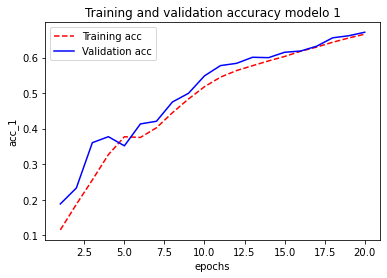

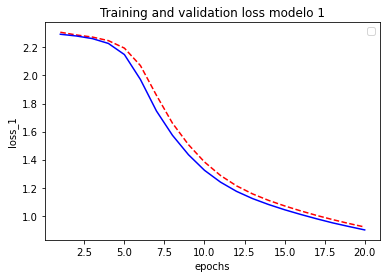

<Figure size 432x288 with 0 Axes>

In [27]:
acc_1     = history_1.history['accuracy']
val_acc_1  = history_1.history['val_accuracy']
loss_1    = history_1.history['loss']
val_loss_1 = history_1.history['val_loss']


epochs   = range(1,len(acc_1)+1,1)

plt.plot ( epochs,     acc_1, 'r--', label='Training acc'  )
plt.plot ( epochs, val_acc_1,  'b', label='Validation acc')
plt.title ('Training and validation accuracy modelo 1')
plt.ylabel('acc_1')
plt.xlabel('epochs')

plt.legend()
plt.figure()


plt.plot ( epochs,     loss_1, 'r--' )
plt.plot ( epochs, val_loss_1,  'b' )
plt.title ('Training and validation loss modelo 1'   )
plt.ylabel('loss_1')
plt.xlabel('epochs')


plt.legend()
plt.figure()




No handles with labels found to put in legend.


<Figure size 432x288 with 0 Axes>

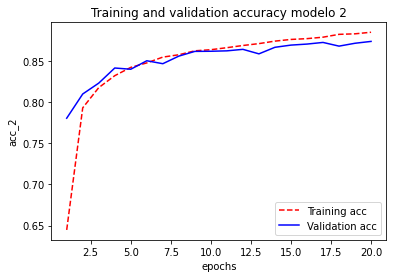

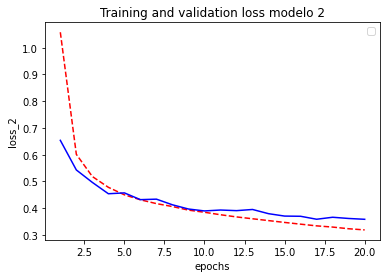

<Figure size 432x288 with 0 Axes>

In [28]:
acc_2     = history_2.history['accuracy']
val_acc_2  = history_2.history['val_accuracy']
loss_2    = history_2.history['loss']
val_loss_2 = history_2.history['val_loss']


epochs   = range(1,len(acc_2)+1,1)

plt.plot ( epochs,     acc_2, 'r--', label='Training acc'  )
plt.plot ( epochs, val_acc_2,  'b', label='Validation acc')
plt.title ('Training and validation accuracy modelo 2')
plt.ylabel('acc_2')
plt.xlabel('epochs')

plt.legend()
plt.figure()


plt.plot ( epochs,     loss_2, 'r--' )
plt.plot ( epochs, val_loss_2,  'b' )
plt.title ('Training and validation loss modelo 2'   )
plt.ylabel('loss_2')
plt.xlabel('epochs')


plt.legend()
plt.figure()

No handles with labels found to put in legend.


<Figure size 432x288 with 0 Axes>

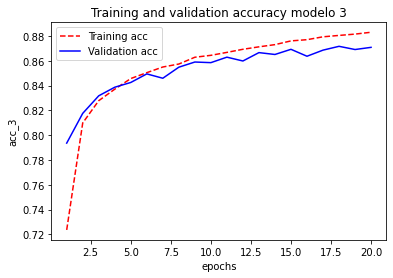

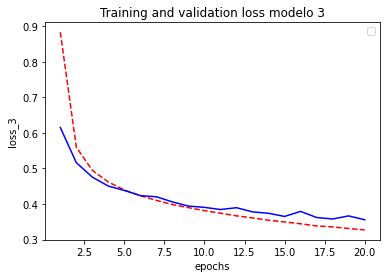

<Figure size 432x288 with 0 Axes>

In [29]:
acc_3     = history_3.history['accuracy']
val_acc_3  = history_3.history['val_accuracy']
loss_3    = history_3.history['loss']
val_loss_3 = history_3.history['val_loss']


epochs   = range(1,len(acc_3)+1,1)

plt.plot ( epochs,     acc_3, 'r--', label='Training acc'  )
plt.plot ( epochs, val_acc_3,  'b', label='Validation acc')
plt.title ('Training and validation accuracy modelo 3')
plt.ylabel('acc_3')
plt.xlabel('epochs')

plt.legend()
plt.figure()


plt.plot ( epochs,     loss_3, 'r--' )
plt.plot ( epochs, val_loss_3,  'b' )
plt.title ('Training and validation loss modelo 3'   )
plt.ylabel('loss_3')
plt.xlabel('epochs')


plt.legend()
plt.figure()

No handles with labels found to put in legend.


<Figure size 432x288 with 0 Axes>

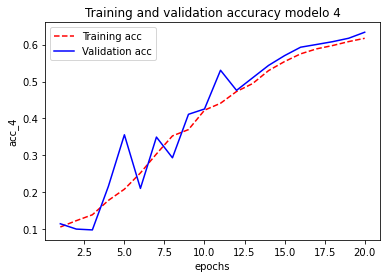

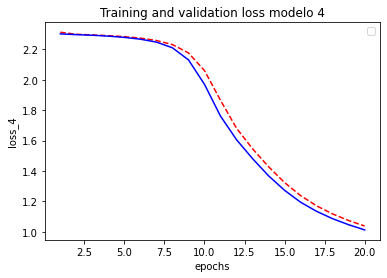

<Figure size 432x288 with 0 Axes>

In [30]:
acc_4     = history_4.history['accuracy']
val_acc_4  = history_4.history['val_accuracy']
loss_4    = history_4.history['loss']
val_loss_4 = history_4.history['val_loss']


epochs   = range(1,len(acc_4)+1,1)

plt.plot ( epochs,     acc_4, 'r--', label='Training acc'  )
plt.plot ( epochs, val_acc_4,  'b', label='Validation acc')
plt.title ('Training and validation accuracy modelo 4')
plt.ylabel('acc_4')
plt.xlabel('epochs')

plt.legend()
plt.figure()


plt.plot ( epochs,     loss_4, 'r--' )
plt.plot ( epochs, val_loss_4,  'b' )
plt.title ('Training and validation loss modelo 4')
plt.ylabel('loss_4')
plt.xlabel('epochs')


plt.legend()
plt.figure()

No handles with labels found to put in legend.


<Figure size 432x288 with 0 Axes>

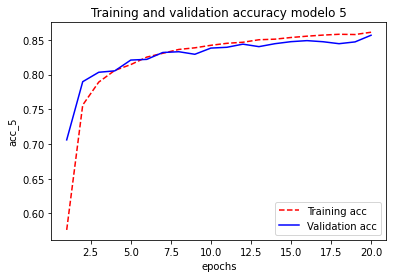

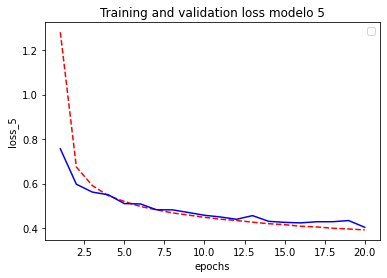

<Figure size 432x288 with 0 Axes>

In [31]:
acc_5     = history_5.history['accuracy']
val_acc_5  = history_5.history['val_accuracy']
loss_5    = history_5.history['loss']
val_loss_5 = history_5.history['val_loss']


epochs   = range(1,len(acc_5)+1,1)

plt.plot ( epochs,     acc_5, 'r--', label='Training acc'  )
plt.plot ( epochs, val_acc_5,  'b', label='Validation acc')
plt.title ('Training and validation accuracy modelo 5')
plt.ylabel('acc_5')
plt.xlabel('epochs')

plt.legend()
plt.figure()


plt.plot ( epochs,     loss_5, 'r--' )
plt.plot ( epochs, val_loss_5,  'b' )
plt.title ('Training and validation loss modelo 5')
plt.ylabel('loss_5')
plt.xlabel('epochs')


plt.legend()
plt.figure()

No handles with labels found to put in legend.


<Figure size 432x288 with 0 Axes>

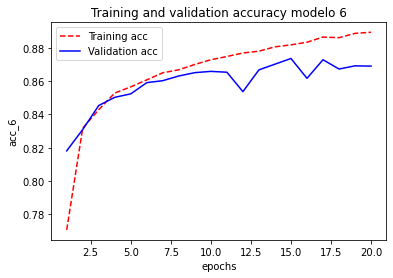

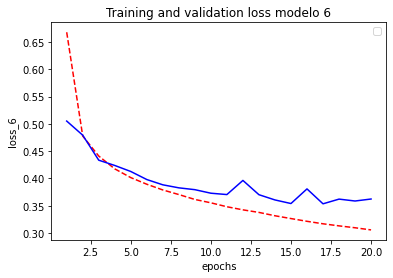

<Figure size 432x288 with 0 Axes>

In [32]:
acc_6     = history_6.history['accuracy']
val_acc_6  = history_6.history['val_accuracy']
loss_6    = history_6.history['loss']
val_loss_6 = history_6.history['val_loss']


epochs   = range(1,len(acc_6)+1,1)

plt.plot ( epochs,     acc_6, 'r--', label='Training acc'  )
plt.plot ( epochs, val_acc_6,  'b', label='Validation acc')
plt.title ('Training and validation accuracy modelo 6')
plt.ylabel('acc_6')
plt.xlabel('epochs')

plt.legend()
plt.figure()


plt.plot ( epochs,     loss_6, 'r--' )
plt.plot ( epochs, val_loss_6,  'b' )
plt.title ('Training and validation loss modelo 6')
plt.ylabel('loss_6')
plt.xlabel('epochs')


plt.legend()
plt.figure()

No handles with labels found to put in legend.


<Figure size 432x288 with 0 Axes>

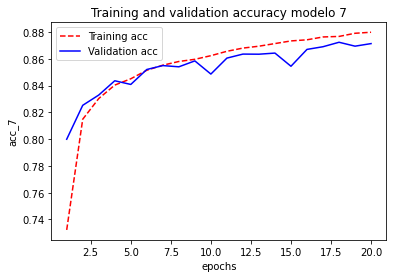

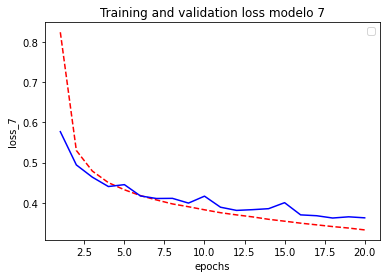

<Figure size 432x288 with 0 Axes>

In [33]:
acc_7     = history_7.history['accuracy']
val_acc_7  = history_7.history['val_accuracy']
loss_7    = history_7.history['loss']
val_loss_7 = history_7.history['val_loss']


epochs   = range(1,len(acc_7)+1,1)

plt.plot ( epochs,     acc_7, 'r--', label='Training acc'  )
plt.plot ( epochs, val_acc_7,  'b', label='Validation acc')
plt.title ('Training and validation accuracy modelo 7')
plt.ylabel('acc_7')
plt.xlabel('epochs')

plt.legend()
plt.figure()


plt.plot ( epochs,     loss_7, 'r--' )
plt.plot ( epochs, val_loss_7,  'b' )
plt.title ('Training and validation loss modelo 7')
plt.ylabel('loss_7')
plt.xlabel('epochs')


plt.legend()
plt.figure()

* En todas las gráficas anteriores, dependiendo del modelo, podemos apreciar que se comportan de forma muy parecida tanto la evolución del Accuracy y de la función de pérdida en ambos contuntos de datos, train y validación.  

## 2. Inicialización de parámetros

En este ejercicio, vamos a evaluar la importancia de una correcta inicialización de parámetros en una red neuronal.

**Ejercicio 2 *(1.25 puntos)***: Partiendo de una red similar a la del ejercicio anterior (usando ya ReLUs), comentar las diferencias que se aprecian en el entrenamiento al utilizar distintas estrategias de inicialización de parámetros. Para ello, inicializar todas las capas con las siguientes estrategias, disponibles en Keras, y analizar sus diferencias:

* Inicialización con ceros.
* Inicialización con una variable aleatoria normal.
* Inicialización con los valores por defecto de Keras para una capa Dense (estrategia *glorot uniform*)


# Modelo 1. Utilizando la Función de activación Relu e inicilizador de pesos y biases 'Zeros' 

In [34]:

model_relu_zero = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(128, activation='relu', kernel_initializer='zeros', bias_initializer='zeros'),
    keras.layers.Dense(64, activation='relu',kernel_initializer='zeros', bias_initializer='zeros'),
    keras.layers.Dense(64, activation='relu', kernel_initializer='zeros', bias_initializer='zeros'),
    keras.layers.Dense(10, activation='softmax')
])


model_relu_zero.compile(optimizer='sgd',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history_relu_zero = model_relu_zero.fit(x_train, y_train, epochs=20, batch_size= 64,
                                        validation_split=0.2, verbose=0, shuffle=True)



print("La accuracy en entrenamiento del modelo_relu_zero es: ", np.max(history_relu_zero.history['accuracy']))
print("La accuracy en validación del modelo_relu_zero es: ", np.max(history_relu_zero.history['val_accuracy']))


acc_relu_zero = round(np.max(history_relu_zero.history['accuracy']),4)
val_acc_relu_zero = round(np.max(history_relu_zero.history['val_accuracy']),4)




La accuracy en entrenamiento del modelo_relu_zero es:  0.1010625
La accuracy en validación del modelo_relu_zero es:  0.09833333641290665


In [35]:
model_relu_zero.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_8 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_29 (Dense)             (None, 128)               100480    
_________________________________________________________________
dense_30 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_31 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_32 (Dense)             (None, 10)                650       
Total params: 113,546
Trainable params: 113,546
Non-trainable params: 0
_________________________________________________________________


# Modelo 2. Utilizando la Función de activación Relu e inicilizador de pesos y biases 'random_normal' 

In [36]:
model_relu_norm = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(128, activation='relu', kernel_initializer='random_normal', bias_initializer='random_normal'),
    keras.layers.Dense(64, activation='relu',kernel_initializer='random_normal', bias_initializer='random_normal'),
    keras.layers.Dense(64, activation='relu', kernel_initializer='random_normal', bias_initializer='random_normal'),
    keras.layers.Dense(10, activation='softmax')
])


model_relu_norm.compile(optimizer='sgd',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history_relu_norm = model_relu_norm.fit(x_train, y_train, epochs=20, batch_size= 64,
                                        validation_split=0.2, verbose=0, shuffle=True)



print("La accuracy en entrenamiento del modelo_relu_norm es: ", np.max(history_relu_norm.history['accuracy']))
print("La accuracy en validación del modelo_relu_norm es: ", np.max(history_relu_norm.history['val_accuracy']))

acc_relu_norm = round(np.max(history_relu_norm.history['accuracy']),4)
val_acc_relu_norm = round(np.max(history_relu_norm.history['val_accuracy']),4)


La accuracy en entrenamiento del modelo_relu_norm es:  0.874125
La accuracy en validación del modelo_relu_norm es:  0.8655833601951599


In [37]:
model_relu_norm.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_9 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_33 (Dense)             (None, 128)               100480    
_________________________________________________________________
dense_34 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_35 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_36 (Dense)             (None, 10)                650       
Total params: 113,546
Trainable params: 113,546
Non-trainable params: 0
_________________________________________________________________


# Modelo 3. Utilizando la Función de activación Relu e inicilizador de pesos y biases 'glorot_uniform'

In [38]:
model_relu_defec = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(128, activation='relu', kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform'),
    keras.layers.Dense(64, activation='relu',kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform'),
    keras.layers.Dense(64, activation='relu', kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform'),
    keras.layers.Dense(10, activation='softmax')
])


model_relu_defec.compile(optimizer='sgd',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history_relu_defec = model_relu_defec.fit(x_train, y_train, epochs=20, batch_size= 64,
                                          validation_split=0.2, verbose=0, shuffle=True)



print("La accuracy en entrenamiento del modelo_relu_defec es: ", np.max(history_relu_defec.history['accuracy']))
print("La accuracy en validación del modelo_relu_defec es: ", np.max(history_relu_defec.history['val_accuracy']))

acc_relu_defec = round(np.max(history_relu_defec.history['accuracy']),4)
val_acc_relu_defec = round(np.max(history_relu_defec.history['val_accuracy']),4)


La accuracy en entrenamiento del modelo_relu_defec es:  0.8848125
La accuracy en validación del modelo_relu_defec es:  0.8727499842643738


In [39]:
model_relu_defec.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_10 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_37 (Dense)             (None, 128)               100480    
_________________________________________________________________
dense_38 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_39 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_40 (Dense)             (None, 10)                650       
Total params: 113,546
Trainable params: 113,546
Non-trainable params: 0
_________________________________________________________________


### Vamos a crear un dataframe con los valores devuelos de los últimos tres modelos para comparar facilmente que método de inicialización nos arroja mejores resultados.

In [40]:
df_2 = pd.DataFrame({'modelo': ['Zeros', 'random_normal', 'glorot_uniform'],  
                     'Accuracy Train' : [acc_relu_zero,acc_relu_norm,acc_relu_defec],
                     'Accuracy Validación' : [val_acc_relu_zero, val_acc_relu_norm, val_acc_relu_defec],
                     
                     })

In [41]:
df_2

,modelo,Accuracy Train,Accuracy Validación
0,Zeros,0.1011,0.0983
1,random_normal,0.8741,0.8656
2,glorot_uniform,0.8848,0.8727


# Conclusiones:
  * La estrategia para incializar los parámetros de pesos y biases en esta red neuronal tiene sus consecuencias.
  * El método que peor resultado devuelve, sin dudas, es inicilizando por ceros los parámetros.
  * Dependiendo de la ejecución de la red, los métodos 'random_normal' y 'glorot_uniform' ofrecen mejores ajustes que el otro método. Estos dos dan resultados muy similiares, pero por norma general, la que trae por defecto es un poco mejor que inicilizar por una variable aleatoria normal.

## 3. Optimizadores

**Ejercicio 3 *(1.25 puntos)***: Partiendo de una red similar a la del ejercicio anterior (utilizando la mejor estrategia de inicialización observada), comparar y analizar las diferencias que se observan  al entrenar con varios de los optimizadores vistos en clase, incluyendo SGD como optimizador básico (se puede explorar el espacio de hiperparámetros de cada optimizador, aunque para optimizadores más avanzados del estilo de adam y RMSprop es buena idea dejar los valores por defecto provistos por Keras).

### Usamos los resultados que vamos realizando en esta actividad, es decir, usamos la función Relu y la forma de incilizar, la que trae por defecto Keras. En este apartado hemos creado seis modelo distintos, cambiando la forma de optimizar. Y comparamos el resultado con otro modelo realizado anteriormente cuyo optimizador usaba SGD. Por tanto, la comparativa final se realiza sobre siete modelos.

## Modelo con Función de activación Relu, usando inicializador de parámetros el que usa por defecto Keras 'glorot uniform' y optimizador 'adam'.

In [42]:
model_relu_defec_adam = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(128, activation='relu', kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform'),
    keras.layers.Dense(64, activation='relu',kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform'),
    keras.layers.Dense(64, activation='relu', kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform'),
    keras.layers.Dense(10, activation='softmax')
])


model_relu_defec_adam.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history_relu_defec_adam = model_relu_defec_adam.fit(x_train, y_train, epochs=20, 
                                                    batch_size= 64,validation_split=0.2, verbose=0, shuffle=True)



print("La accuracy en entrenamiento del modelo_relu_defec_adam es: ", np.max(history_relu_defec_adam.history['accuracy']))
print("La accuracy en validación del modelo_relu_defec_adam es: ", np.max(history_relu_defec_adam.history['val_accuracy']))

acc_relu_defec_adam = round(np.max(history_relu_defec_adam.history['accuracy']),4)
val_acc_relu_defec_adam = round(np.max(history_relu_defec_adam.history['val_accuracy']),4)


La accuracy en entrenamiento del modelo_relu_defec_adam es:  0.93220836
La accuracy en validación del modelo_relu_defec_adam es:  0.8930833339691162


In [43]:
model_relu_defec_adam.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_11 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_41 (Dense)             (None, 128)               100480    
_________________________________________________________________
dense_42 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_43 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_44 (Dense)             (None, 10)                650       
Total params: 113,546
Trainable params: 113,546
Non-trainable params: 0
_________________________________________________________________


## Modelo con Función de activación Relu, usando inicializador de parámetros el que usa por defecto Keras 'glorot uniform' y optimizador 'RMSprop'.

In [44]:
model_relu_defec_RMSprop = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(128, activation='relu', kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform'),
    keras.layers.Dense(64, activation='relu',kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform'),
    keras.layers.Dense(64, activation='relu', kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform'),
    keras.layers.Dense(10, activation='softmax')
])


model_relu_defec_RMSprop.compile(optimizer='RMSprop',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history_relu_defec_RMSprop = model_relu_defec_RMSprop.fit(x_train, y_train, epochs=20, batch_size= 64,
                                                          validation_split=0.2, verbose=0, shuffle=True)



print("La accuracy en entrenamiento del modelo_relu_defec_RMSprop es: ", 
      np.max(history_relu_defec_RMSprop.history['accuracy']))

print("La accuracy en validación del modelo_relu_defec_RMSprop es: ",
      np.max(history_relu_defec_RMSprop.history['val_accuracy']))

acc_relu_defec_RMSprop = round(np.max(history_relu_defec_RMSprop.history['accuracy']),4)
val_acc_relu_defec_RMSprop = round(np.max(history_relu_defec_RMSprop.history['val_accuracy']),4)


La accuracy en entrenamiento del modelo_relu_defec_RMSprop es:  0.92125
La accuracy en validación del modelo_relu_defec_RMSprop es:  0.8859999775886536


In [45]:
model_relu_defec_RMSprop.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_12 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_45 (Dense)             (None, 128)               100480    
_________________________________________________________________
dense_46 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_47 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_48 (Dense)             (None, 10)                650       
Total params: 113,546
Trainable params: 113,546
Non-trainable params: 0
_________________________________________________________________


## Modelo con Función de activación Relu, usando inicializador de parámetros el que usa por defecto Keras 'glorot uniform' y optimizador 'Adagrad'.

In [46]:
model_relu_defec_Adagrad = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(128, activation='relu', kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform'),
    keras.layers.Dense(64, activation='relu',kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform'),
    keras.layers.Dense(64, activation='relu', kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform'),
    keras.layers.Dense(10, activation='softmax')
])


model_relu_defec_Adagrad.compile(optimizer='Adagrad',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history_relu_defec_Adagrad = model_relu_defec_Adagrad.fit(x_train, y_train, epochs=20, 
                                                          batch_size= 64,validation_split=0.2, verbose=0, shuffle=True)



print("La accuracy en entrenamiento del modelo_relu_defec_Adagrad es: ",
      np.max(history_relu_defec_Adagrad.history['accuracy']))

print("La accuracy en validación del modelo_relu_defec_Adagrad es: ",
      np.max(history_relu_defec_Adagrad.history['val_accuracy']))

acc_relu_defec_Adagrad = round(np.max(history_relu_defec_Adagrad.history['accuracy']),4)
val_acc_relu_defec_Adagrad = round(np.max(history_relu_defec_Adagrad.history['val_accuracy']),4)


La accuracy en entrenamiento del modelo_relu_defec_Adagrad es:  0.915375
La accuracy en validación del modelo_relu_defec_Adagrad es:  0.8887500166893005


In [47]:
model_relu_defec_Adagrad.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_13 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_49 (Dense)             (None, 128)               100480    
_________________________________________________________________
dense_50 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_51 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_52 (Dense)             (None, 10)                650       
Total params: 113,546
Trainable params: 113,546
Non-trainable params: 0
_________________________________________________________________


## Modelo con Función de activación Relu, usando inicializador de parámetros el que usa por defecto Keras 'glorot uniform' y optimizador 'Adadelta'.

In [48]:
model_relu_defec_Adadelta = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(128, activation='relu', kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform'),
    keras.layers.Dense(64, activation='relu',kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform'),
    keras.layers.Dense(64, activation='relu', kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform'),
    keras.layers.Dense(10, activation='softmax')
])


model_relu_defec_Adadelta.compile(optimizer='Adadelta',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history_relu_defec_Adadelta = model_relu_defec_Adadelta.fit(x_train, y_train, 
                                                            epochs=20, batch_size= 64,validation_split=0.2,
                                                            verbose=0, shuffle=True)



print("La accuracy en entrenamiento del modelo_relu_defec_Adadelta es: ",
      np.max(history_relu_defec_Adadelta.history['accuracy']))

print("La accuracy en validación del modelo_relu_defec_Adadelta es: ", 
      np.max(history_relu_defec_Adadelta.history['val_accuracy']))

acc_relu_defec_Adadelta = round(np.max(history_relu_defec_Adadelta.history['accuracy']),4)

val_acc_relu_defec_Adadelta = round(np.max(history_relu_defec_Adadelta.history['val_accuracy']),4)


La accuracy en entrenamiento del modelo_relu_defec_Adadelta es:  0.9315208
La accuracy en validación del modelo_relu_defec_Adadelta es:  0.8933333158493042


In [49]:
model_relu_defec_Adadelta.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_14 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_53 (Dense)             (None, 128)               100480    
_________________________________________________________________
dense_54 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_55 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_56 (Dense)             (None, 10)                650       
Total params: 113,546
Trainable params: 113,546
Non-trainable params: 0
_________________________________________________________________


## Modelo con Función de activación Relu, usando inicializador de parámetros el que usa por defecto Keras 'glorot uniform' y optimizador 'Adamax'.

In [50]:
model_relu_defec_Adamax = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(128, activation='relu', kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform'),
    keras.layers.Dense(64, activation='relu',kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform'),
    keras.layers.Dense(64, activation='relu', kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform'),
    keras.layers.Dense(10, activation='softmax')
])


model_relu_defec_Adamax.compile(optimizer='Adamax',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history_relu_defec_Adamax = model_relu_defec_Adamax.fit(x_train, y_train, epochs=20, 
                                                        batch_size= 64,validation_split=0.2, verbose=0)



print("La accuracy en entrenamiento del modelo_relu_defec_Adamax es: ",
      np.max(history_relu_defec_Adamax.history['accuracy']))

print("La accuracy en validación del modelo_relu_defec_Adamax es: ", 
      np.max(history_relu_defec_Adamax.history['val_accuracy']))

acc_relu_defec_Adamax = round(np.max(history_relu_defec_Adamax.history['accuracy']),4)
val_acc_relu_defec_Adamax = round(np.max(history_relu_defec_Adamax.history['val_accuracy']),4)


La accuracy en entrenamiento del modelo_relu_defec_Adamax es:  0.9326042
La accuracy en validación del modelo_relu_defec_Adamax es:  0.893916666507721


In [51]:
model_relu_defec_Adamax.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_15 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_57 (Dense)             (None, 128)               100480    
_________________________________________________________________
dense_58 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_59 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_60 (Dense)             (None, 10)                650       
Total params: 113,546
Trainable params: 113,546
Non-trainable params: 0
_________________________________________________________________


## Modelo con Función de activación Relu, usando inicializador de parámetros el que usa por defecto Keras 'glorot uniform' y optimizador 'Nadam'.

In [52]:
model_relu_defec_Nadam = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(128, activation='relu', kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform'),
    keras.layers.Dense(64, activation='relu',kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform'),
    keras.layers.Dense(64, activation='relu', kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform'),
    keras.layers.Dense(10, activation='softmax')
])


model_relu_defec_Nadam.compile(optimizer='Nadam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history_relu_defec_Nadam = model_relu_defec_Nadam.fit(x_train, y_train, epochs=20, 
                                                      batch_size= 64,validation_split=0.2, verbose=0, shuffle=True)



print("La accuracy en entrenamiento del modelo_relu_defec_Nadam es: ", 
      np.max(history_relu_defec_Nadam.history['accuracy']))

print("La accuracy en validación del modelo_relu_defec_Nadam es: ", 
      np.max(history_relu_defec_Nadam.history['val_accuracy']))

acc_relu_defec_Nadam = round(np.max(history_relu_defec_Nadam.history['accuracy']),4)
val_acc_relu_defec_Nadam = round(np.max(history_relu_defec_Nadam.history['val_accuracy']),4)


La accuracy en entrenamiento del modelo_relu_defec_Nadam es:  0.92954165
La accuracy en validación del modelo_relu_defec_Nadam es:  0.8931666612625122


In [53]:
model_relu_defec_Nadam.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_16 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_61 (Dense)             (None, 128)               100480    
_________________________________________________________________
dense_62 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_63 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_64 (Dense)             (None, 10)                650       
Total params: 113,546
Trainable params: 113,546
Non-trainable params: 0
_________________________________________________________________


## Creamos un dataframe para que la visualización de los resultados sean mas interpretables.

In [54]:
df_3 = pd.DataFrame({'modelo': ['SGD', 'ADAM', 'RMS','ADAGRAD','ADADELTA','ADAMAX', 'NADAM'], 
                     'Accuracy Train' : [acc_relu_defec,acc_relu_defec_adam,
                                         acc_relu_defec_RMSprop,acc_relu_defec_Adagrad,
                                         acc_relu_defec_Adadelta,acc_relu_defec_Adamax,
                                         acc_relu_defec_Nadam],
                     'Accuracy Validación' : [val_acc_relu_defec,val_acc_relu_defec_adam, 
                                              val_acc_relu_defec_RMSprop,val_acc_relu_defec_Adagrad,
                                              val_acc_relu_defec_Adadelta,val_acc_relu_defec_Adamax,
                                              val_acc_relu_defec_Nadam],
                    })
                    


In [55]:
df_3

,modelo,Accuracy Train,Accuracy Validación
0,SGD,0.8848,0.8727
1,ADAM,0.9322,0.8931
2,RMS,0.9212,0.8860
3,ADAGRAD,0.9154,0.8888
4,ADADELTA,0.9315,0.8933
5,ADAMAX,0.9326,0.8939
6,NADAM,0.9295,0.8932


In [56]:
df_3.sort_values(['Accuracy Train', 'Accuracy Validación'])

,modelo,Accuracy Train,Accuracy Validación
0,SGD,0.8848,0.8727
3,ADAGRAD,0.9154,0.8888
2,RMS,0.9212,0.8860
6,NADAM,0.9295,0.8932
4,ADADELTA,0.9315,0.8933
1,ADAM,0.9322,0.8931
5,ADAMAX,0.9326,0.8939


In [57]:
df_3.sort_values(['Accuracy Train'], ascending=[False])

,modelo,Accuracy Train,Accuracy Validación
5,ADAMAX,0.9326,0.8939
1,ADAM,0.9322,0.8931
4,ADADELTA,0.9315,0.8933
6,NADAM,0.9295,0.8932
2,RMS,0.9212,0.8860
3,ADAGRAD,0.9154,0.8888
0,SGD,0.8848,0.8727


In [58]:
df_3.sort_values(['Accuracy Validación'], ascending=[False])

,modelo,Accuracy Train,Accuracy Validación
5,ADAMAX,0.9326,0.8939
4,ADADELTA,0.9315,0.8933
6,NADAM,0.9295,0.8932
1,ADAM,0.9322,0.8931
3,ADAGRAD,0.9154,0.8888
2,RMS,0.9212,0.8860
0,SGD,0.8848,0.8727


# Conclusiones:
  * El modelo que tiene mas Accuracy en el entrenamiento es Optimizador 'Adam' , en validación se encontraría en tercer lugar con 0.0028 mas bajo que el primero 'Adamax'. Por lo tanto elegimos como mejor optimizador 'Adam'

## 4. Regularización y red final *(1.25 puntos)*

**Ejercicio 4.1**: Entrenar una red final que sea capaz de obtener una accuracy en el validation set cercana al 90%. Para ello, combinar todo lo aprendido anteriormente y utilizar técnicas de regularización para evitar overfitting. Algunos de los elementos que pueden tenerse en cuenta son los siguientes.

* Número de capas y neuronas por capa
* Optimizadores y sus parámetros
* Batch size
* Unidades de activación
* Uso de capas dropout, regularización L2, regularización L1...
* Early stopping (se puede aplicar como un callback de Keras, o se puede ver un poco "a ojo" cuándo el modelo empieza a caer en overfitting y seleccionar el número de epochs necesarias)
* Batch normalization

Si los modelos entrenados anteriormente ya se acercaban al valor requerido de accuracy, probar distintas estrategias igualmente y comentar los resultados.

Explicar brevemente la estrategia seguida y los modelos probados para obtener el modelo final, que debe verse entrenado en este Notebook. No es necesario guardar el entrenamiento de todos los modelos que se han probado, es suficiente con explicar cómo se ha llegado al modelo final.

* Para el modelo definitivo hemos usado:
  * Modelo secuencial.
  
  * Capa de entrada con las imágenes en escala de grises con dimensiones 28 x 28.
  
  * Cinco Capas densas con 1024 neuronas las cuatro primeras y la quinta con 512 neuronas. Todas las neuronas de una una capa están conectadas con todas las de las siguiente capa.  
  
  * Tres capas de Dropout al 50% de neuronas para desactivar al azar, para poner más difícil la memorización por parte de la red y evitar el Overfitting. Esto pone en contradicción lo explicado en el punto anterior. Con Dropout, antes de la función de pérdida, lo que hace es elegir al azar, cada vez que se pasa por esa capa, la mitad de las neuronas para reazlizar el siguiente paso.
  
  * Función de activación relus en todas las capas, menos en la última que por diseño del problema debe ser softmax (explicado en la parte primera de esta actividad).
  
  * Inicialiamos los pesos y los biases con la opción que viene por defecto que es: glorot_uniform, que hemos querido reflejar introduciendolo en el modelo.
  
  * Aplicamos la regularización tipo L2 para los pesos y biases. Lo que hacemos es sumar a la función de coste un parámetro de regularización, favorecemos que los valores de los parámetros sean pequeños.
  
  * Optimimizador Adam con un learning rate 0.0001. Hemos probado distintos valores de este hiperparámetro, incluido la posibilidad de usar el método 'decay' y el mejor resultado nos lo devuelve ese learning rate. Por lo tanto, en este caso, hemos probado valores mucho mas pequeños y bo mejora el resultado.  
  
  * La función de pérdida o coste, la que hemos usado durante todo el ejercicio: sparse_categorical_crossentropy.
  
  * Como Métrica para ver la bondad del ajuste del modelo, Accuracy.
  
  * Aumentamos las epochs a 100. 
  
  * Sacamos del conjunto de test un 20% de observaciones para aplicar el modelo, antes de usarlo en el conjunto test. Para ver cómo se comporta con imágenes que no ha visto nunca.
  
  * Continuamos con shufle para dar mas aleatoriedad a la hora de elegir los conjuntos de test, validación y train, ya que baraja las observaciones de los mismos.
  
  * Usamos Early stopping para detectar cuando la red está cayendo en Overfitting en el conjunto de validación y determinar en que epochs se produce. En nuestro caso, cuando deja de disminuir en diez épocas seguidas el valor de la función de pérdida en el conjunto de validación, para de ejecutarse el modelo.
  
  * Monitorizamos la ejecución.
  
  * El objetivo es alcanzar como mínimo en en la métrica de Accuracy en el conjunto de validación un 0.90

In [59]:
model_def= keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    
    keras.layers.Dense(1024, activation='relu', 
                       kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform', 
                       activity_regularizer=regularizers.l2(1e-5), bias_regularizer=regularizers.l2(1e-4)),
    
    keras.layers.Dropout(0.5),
    
    keras.layers.Dense(1024, activation='relu',
                       kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform', 
                       activity_regularizer=regularizers.l2(1e-5), bias_regularizer=regularizers.l2(1e-4)),
    
    keras.layers.Dropout(0.5),
    
    keras.layers.Dense(1024, activation='relu',
                       kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform', 
                       activity_regularizer=regularizers.l2(1e-5), bias_regularizer=regularizers.l2(1e-4)),
    
    keras.layers.Dropout(0.5),
    
    keras.layers.Dense(1024, activation='relu', 
                       kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform', 
                       activity_regularizer=regularizers.l2(1e-5), bias_regularizer=regularizers.l2(1e-4)),

    keras.layers.Dropout(0.5),

    keras.layers.Dense(512, activation='relu', 
                       kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform', 
                       activity_regularizer=regularizers.l2(1e-5), bias_regularizer=regularizers.l2(1e-4)),

    keras.layers.Dropout(0.5),
    
    keras.layers.Dense(10, activation='softmax'),
])




optimizer = keras.optimizers.adam(lr=0.0001) 



model_def.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

stop = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

history_model_def = model_def.fit(x_train, y_train, epochs=100, batch_size= 64,validation_split=0.2, 
                                  verbose=1, shuffle=True, callbacks=[stop])


acc_def = round(np.max(history_model_def.history['accuracy']),4)
val_acc_def = round(np.max(history_model_def.history['val_accuracy']),4)





print("La accuracy en entrenamiento del modelo definitivo es: ", acc_def)
print("La accuracy en validación del modelo definitivo es: ", val_acc_def)

Train on 48000 samples, validate on 12000 samples
Epoch 1/100
48000/48000 [==============================] - 10s 200us/step - loss: 1.3475 - accuracy: 0.5627 - val_loss: 0.6574 - val_accuracy: 0.7949
Epoch 2/100
48000/48000 [==============================] - 9s 195us/step - loss: 0.7041 - accuracy: 0.7906 - val_loss: 0.5273 - val_accuracy: 0.8416
Epoch 3/100
48000/48000 [==============================] - 9s 194us/step - loss: 0.5876 - accuracy: 0.8288 - val_loss: 0.4725 - val_accuracy: 0.8599
Epoch 4/100
48000/48000 [==============================] - 10s 198us/step - loss: 0.5291 - accuracy: 0.8449 - val_loss: 0.4446 - val_accuracy: 0.8682
Epoch 5/100
48000/48000 [==============================] - 9s 196us/step - loss: 0.4937 - accuracy: 0.8544 - val_loss: 0.4467 - val_accuracy: 0.8662
Epoch 6/100
48000/48000 [==============================] - 9s 194us/step - loss: 0.4669 - accuracy: 0.8602 - val_loss: 0.4162 - val_accuracy: 0.8748
Epoch 7/100
48000/48000 [=============================

48000/48000 [==============================] - 10s 199us/step - loss: 0.2242 - accuracy: 0.9283 - val_loss: 0.3147 - val_accuracy: 0.9017
Epoch 56/100
48000/48000 [==============================] - 10s 200us/step - loss: 0.2256 - accuracy: 0.9285 - val_loss: 0.3173 - val_accuracy: 0.8974
Epoch 57/100
48000/48000 [==============================] - 10s 207us/step - loss: 0.2215 - accuracy: 0.9293 - val_loss: 0.3078 - val_accuracy: 0.8994
Epoch 58/100
48000/48000 [==============================] - 10s 201us/step - loss: 0.2163 - accuracy: 0.9307 - val_loss: 0.3259 - val_accuracy: 0.9018
Epoch 59/100
48000/48000 [==============================] - 9s 196us/step - loss: 0.2151 - accuracy: 0.9321 - val_loss: 0.3189 - val_accuracy: 0.9009
Epoch 60/100
48000/48000 [==============================] - 9s 195us/step - loss: 0.2130 - accuracy: 0.9315 - val_loss: 0.3142 - val_accuracy: 0.9040
Epoch 61/100
48000/48000 [==============================] - 9s 196us/step - loss: 0.2148 - accuracy: 0.9332 -

In [60]:
model_def.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_17 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_65 (Dense)             (None, 1024)              803840    
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_66 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_67 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dropout_3 (Dropout)          (None, 1024)            

No handles with labels found to put in legend.


<Figure size 432x288 with 0 Axes>

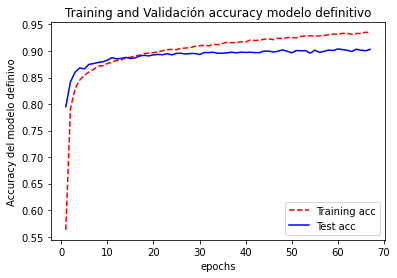

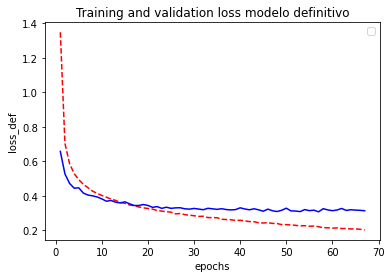

<Figure size 432x288 with 0 Axes>

In [61]:
acc_def     = history_model_def.history['accuracy']
val_acc_def  = history_model_def.history['val_accuracy']
loss_def    = history_model_def.history['loss']
val_loss_def = history_model_def.history['val_loss']


epochs  = range(1,len(acc_def)+1,1)


plt.plot ( epochs,     acc_def, 'r--', label='Training acc'  )
plt.plot ( epochs, val_acc_def,  'b', label='Test acc')
plt.title ('Training and Validación accuracy modelo definitivo')
plt.ylabel('Accuracy del modelo definivo')
plt.xlabel('epochs')

plt.legend()
plt.figure()


plt.plot ( epochs,     loss_def, 'r--' )
plt.plot ( epochs, val_loss_def,  'b' )
plt.title ('Training and validation loss modelo definitivo'   )
plt.ylabel('loss_def')
plt.xlabel('epochs')


plt.legend()
plt.figure()

* Pdemos observar en ambas gráficas que se comportan de manera muy similar, por lo tanto, podemos decor que no se aprecia Overfitting.

### Evaluación del modelo en datos de test

Una vez elegido el que creemos que es nuestro mejor modelo a partir de la estimación que hemos visto en los datos de validación, es hora de utilizar los datos de test para ver cómo se comporta nuestro modelo ante nuevos datos. Si hemos hecho bien las cosas, este número debería ser parecido al valor de nuestra estimación vista en los datos de validación.

**Pregunta 4.2**. Utilizando nuestro mejor modelo, obtener la accuracy resultante en el dataset de test. Comentar este resultado.

In [62]:
acc_test_def = round((model_def.evaluate(x_test, y_test)[1]),4)

10000/10000 [==============================] - 1s 74us/step


In [63]:
print("La accuracy del modelo definito con los datos de test es: ", acc_test_def)

La accuracy del modelo definito con los datos de test es:  0.8987


* Nuestro mejor modelo tiene una Accuracy del 89.33 % , es decir de 100 imagenes clasifica correctamente a 89.

In [64]:
y_pred = model_def.predict_classes(x_test)

In [65]:
dic_clases = {0:"T-shirt/top",1:"Trouser",2:"Pullover",3:"Dress",4:"Coat",5:"Sandal",6:"Shirt",
              7:"Sneaker",8:"Bag",9:"Ankle boot"}

* Vamos a implementar otras métricas para ver el comportamiento del modelo, podemos ver que hay clases que mejora la predicción, por ejemplo para los Trousers que llega al 99%. A la vez lo que peor clasifica es la clase Shirt.

In [66]:
target_names = [dic_clases[x] for x in range(0,10)]
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

 T-shirt/top       0.85      0.86      0.85      1000
     Trouser       0.99      0.98      0.98      1000
    Pullover       0.82      0.82      0.82      1000
       Dress       0.88      0.93      0.90      1000
        Coat       0.83      0.82      0.82      1000
      Sandal       0.97      0.98      0.98      1000
       Shirt       0.75      0.70      0.72      1000
     Sneaker       0.95      0.96      0.96      1000
         Bag       0.97      0.97      0.97      1000
  Ankle boot       0.98      0.96      0.97      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



* A continuación vamos a imprimir ejemplos de imagenes que el modelo no es capaz de clasificar bien. Para ello creamos variables que incluyan por separado las que si clasifica bien, comparando con su valor real y predicho, con las que no clasifican correctamente.

In [67]:
predicciones_correctas = np.nonzero(y_pred == y_test)[0]
predicciones_incorrectas = np.nonzero(y_pred != y_test)[0]

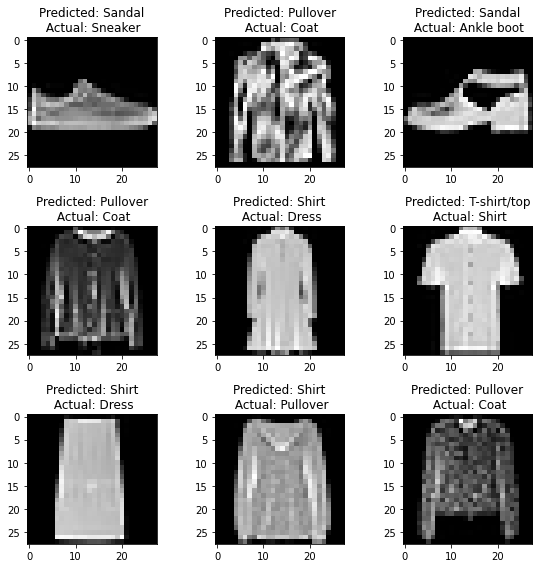

In [68]:
plt.figure(figsize=(8,8))
for i, incorrect in enumerate(predicciones_incorrectas[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(x_test[incorrect].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted: {}\n Actual: {}".format(dic_clases[y_pred[incorrect]], dic_clases[y_test[incorrect]]))
    
plt.tight_layout()

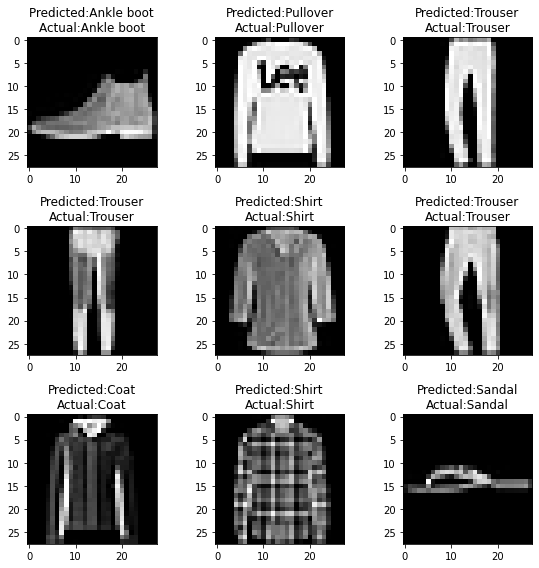

In [69]:
plt.figure(figsize=(8,8))

for i, correct in enumerate(predicciones_correctas[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(x_test[correct].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted:{}\nActual:{}".format(dic_clases[y_pred[correct]],dic_clases[y_test[correct]]))

plt.tight_layout()

* Vamos a crear una matriz que nos muestre los valores numéricos entre las imagenes que ha predicho bien y las que no lo ha hecho correctamente. Por ejemplo existen cuatro imagenes que en realidad son Coat y el modelo lo ha etiquetado como T-shirt/top. Podemos analizar con mas detalle porque la etiqueta Shirt el modelo no da valores buenos ya que los confunde sobre todo con T-shirt/top.
* En la diagonla principal, se encuentran los valores predichos correctamente.

In [70]:
matrix = pd.DataFrame(confusion_matrix(y_test, y_pred), index=target_names, columns=target_names)
matrix.index.name = 'Predicted'
matrix.columns.name = 'Real'
matrix

Real,T-shirt/top,Trouser,Pullover,Dress,Coat,Sandal,Shirt,Sneaker,Bag,Ankle boot
Predicted,,,,,,,,,,
T-shirt/top,862,0,14,24,3,1,91,0,5,0
Trouser,1,977,2,16,2,0,1,0,1,0
Pullover,15,2,822,13,81,0,63,0,4,0
Dress,14,9,10,925,22,0,16,1,3,0
Coat,0,1,85,35,819,0,57,0,3,0
Sandal,0,0,0,0,0,981,0,12,1,6
Shirt,121,1,72,35,61,1,700,0,9,0
Sneaker,0,0,0,0,0,18,0,964,0,18
Bag,4,1,2,6,2,3,4,4,974,0
